[Table of Contents](./table_of_contents.ipynb)

# Particle Filters

In [1]:
from __future__ import division, print_function

from time import sleep

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from numpy.random import uniform, random, seed
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

In [2]:
def gimme_some_pi(N=300, display_visuals=False):
    pts = uniform(-1, 1, (N, 2))

    # distance from (0,0) 
    dist = np.linalg.norm(pts, axis=1)
    in_circle = dist <= 1

    pts_in_circle = np.count_nonzero(in_circle)
    # surface is π since radius is 1.0
    pi = 4 * (pts_in_circle / N)

    # plot results
    if display_visuals:
        plt.scatter(pts[in_circle,0], pts[in_circle,1], 
                    marker=',', edgecolor='k', s=1)
        plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
                    marker=',', edgecolor='r', s=1)
        plt.axis('equal')
    
    return pi, np.pi-pi
#     print('mean pi(N={})= {:.4f}'.format(N, pi))
#     print('err  pi(N={})= {:.4f}'.format(N, np.pi-pi))

pi=3.132  pi_error=0.01


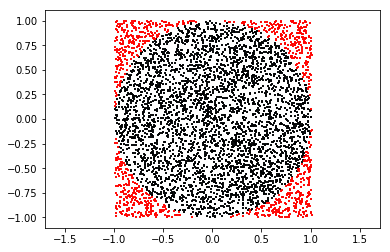

In [3]:
pi, pi_error = gimme_some_pi(N=5000, display_visuals=True)

print ("pi={}  pi_error={}".format(np.round(pi, 3), np.round(pi_error, 3)))

N_range = np.arange(1, 200000, 1000)
errs = [np.abs(gimme_some_pi(N=N)[1]) for N in N_range]


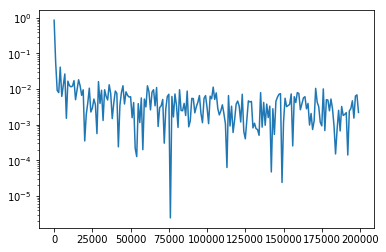

In [4]:
plt.yscale('log')
plt.plot(N_range, errs)


-----------------------------

-----------------------------

## Bootstrap Particle Filter Algorithm

0. **Randomly generate a bunch of particles**
<img src="img/initialize_from_prior_step.png"  alt="Drawing" style="width: 400px;"/>

    Particles can have position, heading, and/or whatever other state variable you need to estimate. Each has a weight (probability) indicating how likely it matches the actual state of the system. Initialize each with the same weight.
 


1. **Predict next state of the particles**
<img src="img/predict_step.png"  alt="Drawing" style="width: 400px;"/>

 Move the particles based on how you predict the real system is behaving.




2. **Update the weights**
<img src="img/update_step.png"  alt="Drawing" style="width: 400px;"/>

  Update the weighting of the particles based on the measurement. Particles that closely match the measurements are weighted higher than particles that don't.
  
  
3. **Resample**
<img src="img/resampling_step.png"  alt="Drawing" style="width: 400px;"/>

  Discard highly improbable particles and replace them with copies of the more probable particles.


4. **Optionally, Compute Estimate**

  Optionally, compute weighted mean and covariance of the set of particles to get a state estimate.


--------------------

--------------------

0. **Randomly generate a bunch of particles**
<img src="img/initialize_from_prior_step.png"  alt="Drawing" style="width: 400px;"/>

    Particles can have position, heading, and/or whatever other state variable you need to estimate. Each has a weight (probability) indicating how likely it matches the actual state of the system. Initialize each with the same weight.


In [5]:
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

For example:

In [6]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.43775342, 0.39948563, 2.40145037],
       [0.17549344, 0.80292869, 5.37287912],
       [0.85254277, 0.96260742, 4.13819866],
       [0.39766986, 0.59485557, 3.66532585]])

--------------------

--------------------


1. **Predict next state of the particles**
<img src="img/predict_step.png"  alt="Drawing" style="width: 400px;"/>

 Move the particles based on how you predict the real system is behaving.




In [7]:
def predict(particles, polar_velocity, polar_velocity_stddev, dt=1.):
    """ move according to control input polar_velocity (heading change, speed)
    with noise polar_velocity_stddev a.k.a. Q (stddev of heading change, stddev of speed)`"""

    N = len(particles)
    # update heading of particles all at once
    particles[:, 2] += polar_velocity[0] + (randn(N) * polar_velocity_stddev[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (polar_velocity[1] * dt) + (randn(N) * polar_velocity_stddev[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

--------------------

--------------------

2. **Update the weights**
<img src="img/update_step.png"  alt="Drawing" style="width: 400px;"/>

  Update the weighting of the particles based on the measurement. Particles that closely match the measurements are weighted higher than particles that don't. Normalizing the weights so they sum to one turns them into a probability distribution. 
  Measurements here = range measurements. 
  Likelihood of (noisy!) Range measurements given the current particle-estimated robot position.
  
  
  

In [8]:
def update(particles, particle_weights, sensor_measurements, sensor_noise_stddev, true_landmarks):
    for i, landmark in enumerate(landmarks):
        # distance as per (given) the particle state (i.e. the x in p(y|x))
        estimated_distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        # measurement model is normal law centered on estimated state (i.e. distances/ranges from the robot to landmarks)
        # all we know about the robot is estimated from the particles 
        particle_weights *= scipy.stats.norm(estimated_distance, sensor_noise_stddev).pdf(sensor_measurements[i])

    particle_weights += 1.e-300      # avoid round-off to zero
    particle_weights /= sum(particle_weights) # normalize

--------------------

--------------------

3. **Resample**
<img src="img/resampling_step.png"  alt="Drawing" style="width: 400px;"/>

  Discard highly improbable particles and replace them with copies of the more probable particles.



In the literature this part of the algorithm is called *Sequential Importance Sampling*, or SIS. The equation for the weights is called the *importance density*. I will give these theoretical underpinnings in a following section. For now I hope that this makes intuitive sense. If we weight the particles according to how well they match the measurements they are probably a good sample for the probability distribution of the system after incorporating the measurements. Theory proves this is so. The weights are the *likelihood* in Bayes theorem. Different problems will need to tackle this step in slightly different ways but this is the general idea.

In [9]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

--------------------

--------------------

4. **Optionally, Compute Estimate**

  Optionally, compute weighted mean and covariance of the set of particles to get a state estimate.

$$ \mu = \frac{1}{N}\sum\limits_{i=1}^N w^ix^i$$

In [10]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

--------------------

--------------------

## Let's piece those steps together for a simple end-to-end Particle Filter

To implement the filter we need to create the particles and the landmarks. We then execute a loop, successively calling `predict`, `update`, `resampling`, and then computing the new state estimate with `estimate`.

In [11]:
# true, known, surveyed position of landmarks. 
# The robot uses a colocated sensor to measure ranges to the landmarks. 
landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])

In [12]:
def get_sensor_measurements(landmarks, sensor_position, sensor_std_dev):
    return (norm(landmarks - sensor_position, axis=1) + 
              (randn(len(landmarks)) * sensor_std_dev))

In [13]:
def run_particle_filter(N_particles, num_iterations=3, sensor_std_dev=0.1, 
                        do_plot=False, plot_particles=False,
                        x_lim=(0, 20), y_lim=(0, 20), 
                        does_resampling=True,
                        is_initialized=None):
    
    # create particles and weights
    particles = create_uniform_particles(x_lim, y_lim, (0, 2.*np.pi), N_particles)
    weights = np.ones(N_particles) / N_particles

    rover_position = np.array([0., 0.])
    for x in range(num_iterations):
        # move true robot/sensor position
        rover_position += (1, 1)

        # sensor-measured distances from robot to each landmark. Truth + some sensor noise
        sensor_measurements = get_sensor_measurements(landmarks=landmarks,
                                                      sensor_position=rover_position,
                                                      sensor_std_dev=sensor_std_dev)

        # move particles diagonally forward to (x+1, x+1), no angular velocity
        predict(particles,
                polar_velocity=(0.00, np.sqrt(2.)),
                polar_velocity_stddev=(.2, .05))
        
        # incorporate measurements info. does not alter the particle positions, only alters the weights
        update(particles=particles,
               particle_weights=weights,
               sensor_measurements=sensor_measurements,
               sensor_noise_stddev=sensor_std_dev, 
               true_landmarks=landmarks)

        # resampling
        if does_resampling:
            simple_resample(particles=particles, weights=weights)
        
        # get an estimate at current time step   
        mu, var = estimate(particles, weights)

    print('final position error, variance:\n\t', mu - np.array([num_iterations, num_iterations]), var)


In [14]:
# seed(2)  # seed(2) + N_particles==1000 will give you bad estimates but not other seeds ==> demo

run_particle_filter(N_particles=40000,
                    plot_particles=False,
                    num_iterations=20,
                    does_resampling=True,
                    x_lim=(0,8), y_lim=(0,8))

final position error, variance:
	 [-0.13139883  0.13762452] [0.00474759 0.00717713]


---------------

--------------------

In [203]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

def run_particle_filter(N_particles, num_iterations=3, sensor_std_dev=0.1, 
                        plot_trace=False, plot_particles=False, plot_trace_line=False,
                        x_lim=(0, 20), y_lim=(0, 20), 
                        does_resampling=True, does_slow_down=True,
                        is_initialized=None,
                        fig_=None):

    plt.xlim(*x_lim)
    plt.ylim(*y_lim)

    # create particles and weights
    particles = create_uniform_particles(x_lim, y_lim, (0, 2.*np.pi), N_particles)
    weights = np.ones(N_particles) / N_particles
    rover_position_estimates = []
    rover_position = np.array([0., 0.])

    if plot_particles:
        alpha = .20
        if N_particles > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N_particles)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
        p1 = plt.scatter(rover_position[0], rover_position[1], marker='+',
                         color='k', s=180, lw=3)
        mu_, _ = estimate(particles, weights)
        p2 = plt.scatter(mu_[0], mu_[1], marker='s', color='r')
        plt.legend([p1, p2], ['Actual', 'Particle Filter'], loc=4, numpoints=1)
        fig_.canvas.draw()
        if does_slow_down:
            sleep(8)
        plt.clf()
    
    for x in range(num_iterations):
        # move true robot/sensor position
        rover_position += (1, 1)

        # sensor-measured distances from robot to each landmark. Truth + some sensor noise
        sensor_measurements = get_sensor_measurements(landmarks=landmarks,
                                                      sensor_position=rover_position,
                                                      sensor_std_dev=sensor_std_dev)

        # move particles diagonally forward to (x+1, x+1), no angular velocity
        predict(particles,
                polar_velocity=(0.00, np.sqrt(2.)),
                polar_velocity_stddev=(.2, .05))
        
        # incorporate measurements info. does not alter the particle positions, only alters the weights
        update(particles=particles,
               particle_weights=weights,
               sensor_measurements=sensor_measurements,
               sensor_noise_stddev=sensor_std_dev, 
               true_landmarks=landmarks)
        
        if does_resampling:
            if neff(weights) < N_particles/4000:
                simple_resample(particles=particles, weights=weights)
                plt.text(rover_position[0]-0.15, 0.1, "R", fontdict={'fontsize': 18, 
#                                                                                         'fontname': 'Helvetica',
                                                                                        'fontweight': 'bold',
                                                                    'color': 'blue'})
                fig_.canvas.draw()
                if does_slow_down:
                    sleep(2.0)
        # get an estimate at current time step   
        mu, var = estimate(particles, weights)
        rover_position_estimates.append(mu)

        if plot_particles:
#             plt.clf()
            plt.scatter(particles[:, 0], particles[:, 1], alpha=0.4,
                        color='g', s=np.power(weights*N_particles, 0.5)*3.0)
            plt.xlim(*x_lim)
            plt.ylim(*y_lim)
            fig_.canvas.draw()

        if plot_trace:
            p1 = plt.scatter(rover_position[0], rover_position[1], marker='+',
                             color='k', s=180, lw=3)
            p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
            rover_position_estimates_array = np.array(rover_position_estimates)
            if plot_trace_line:
                plt.plot(rover_position_estimates_array[:, 0], rover_position_estimates_array[:, 1])
            plt.legend([p1, p2], ['Actual', 'Particle Filter'], loc=4, numpoints=1)
            plt.xlim(*x_lim)
            plt.ylim(*y_lim)
            fig_.canvas.draw()
            if does_slow_down:
                sleep(2.0)
    
    fig_.canvas.draw()

    return fig_


<IPython.core.display.Javascript object>


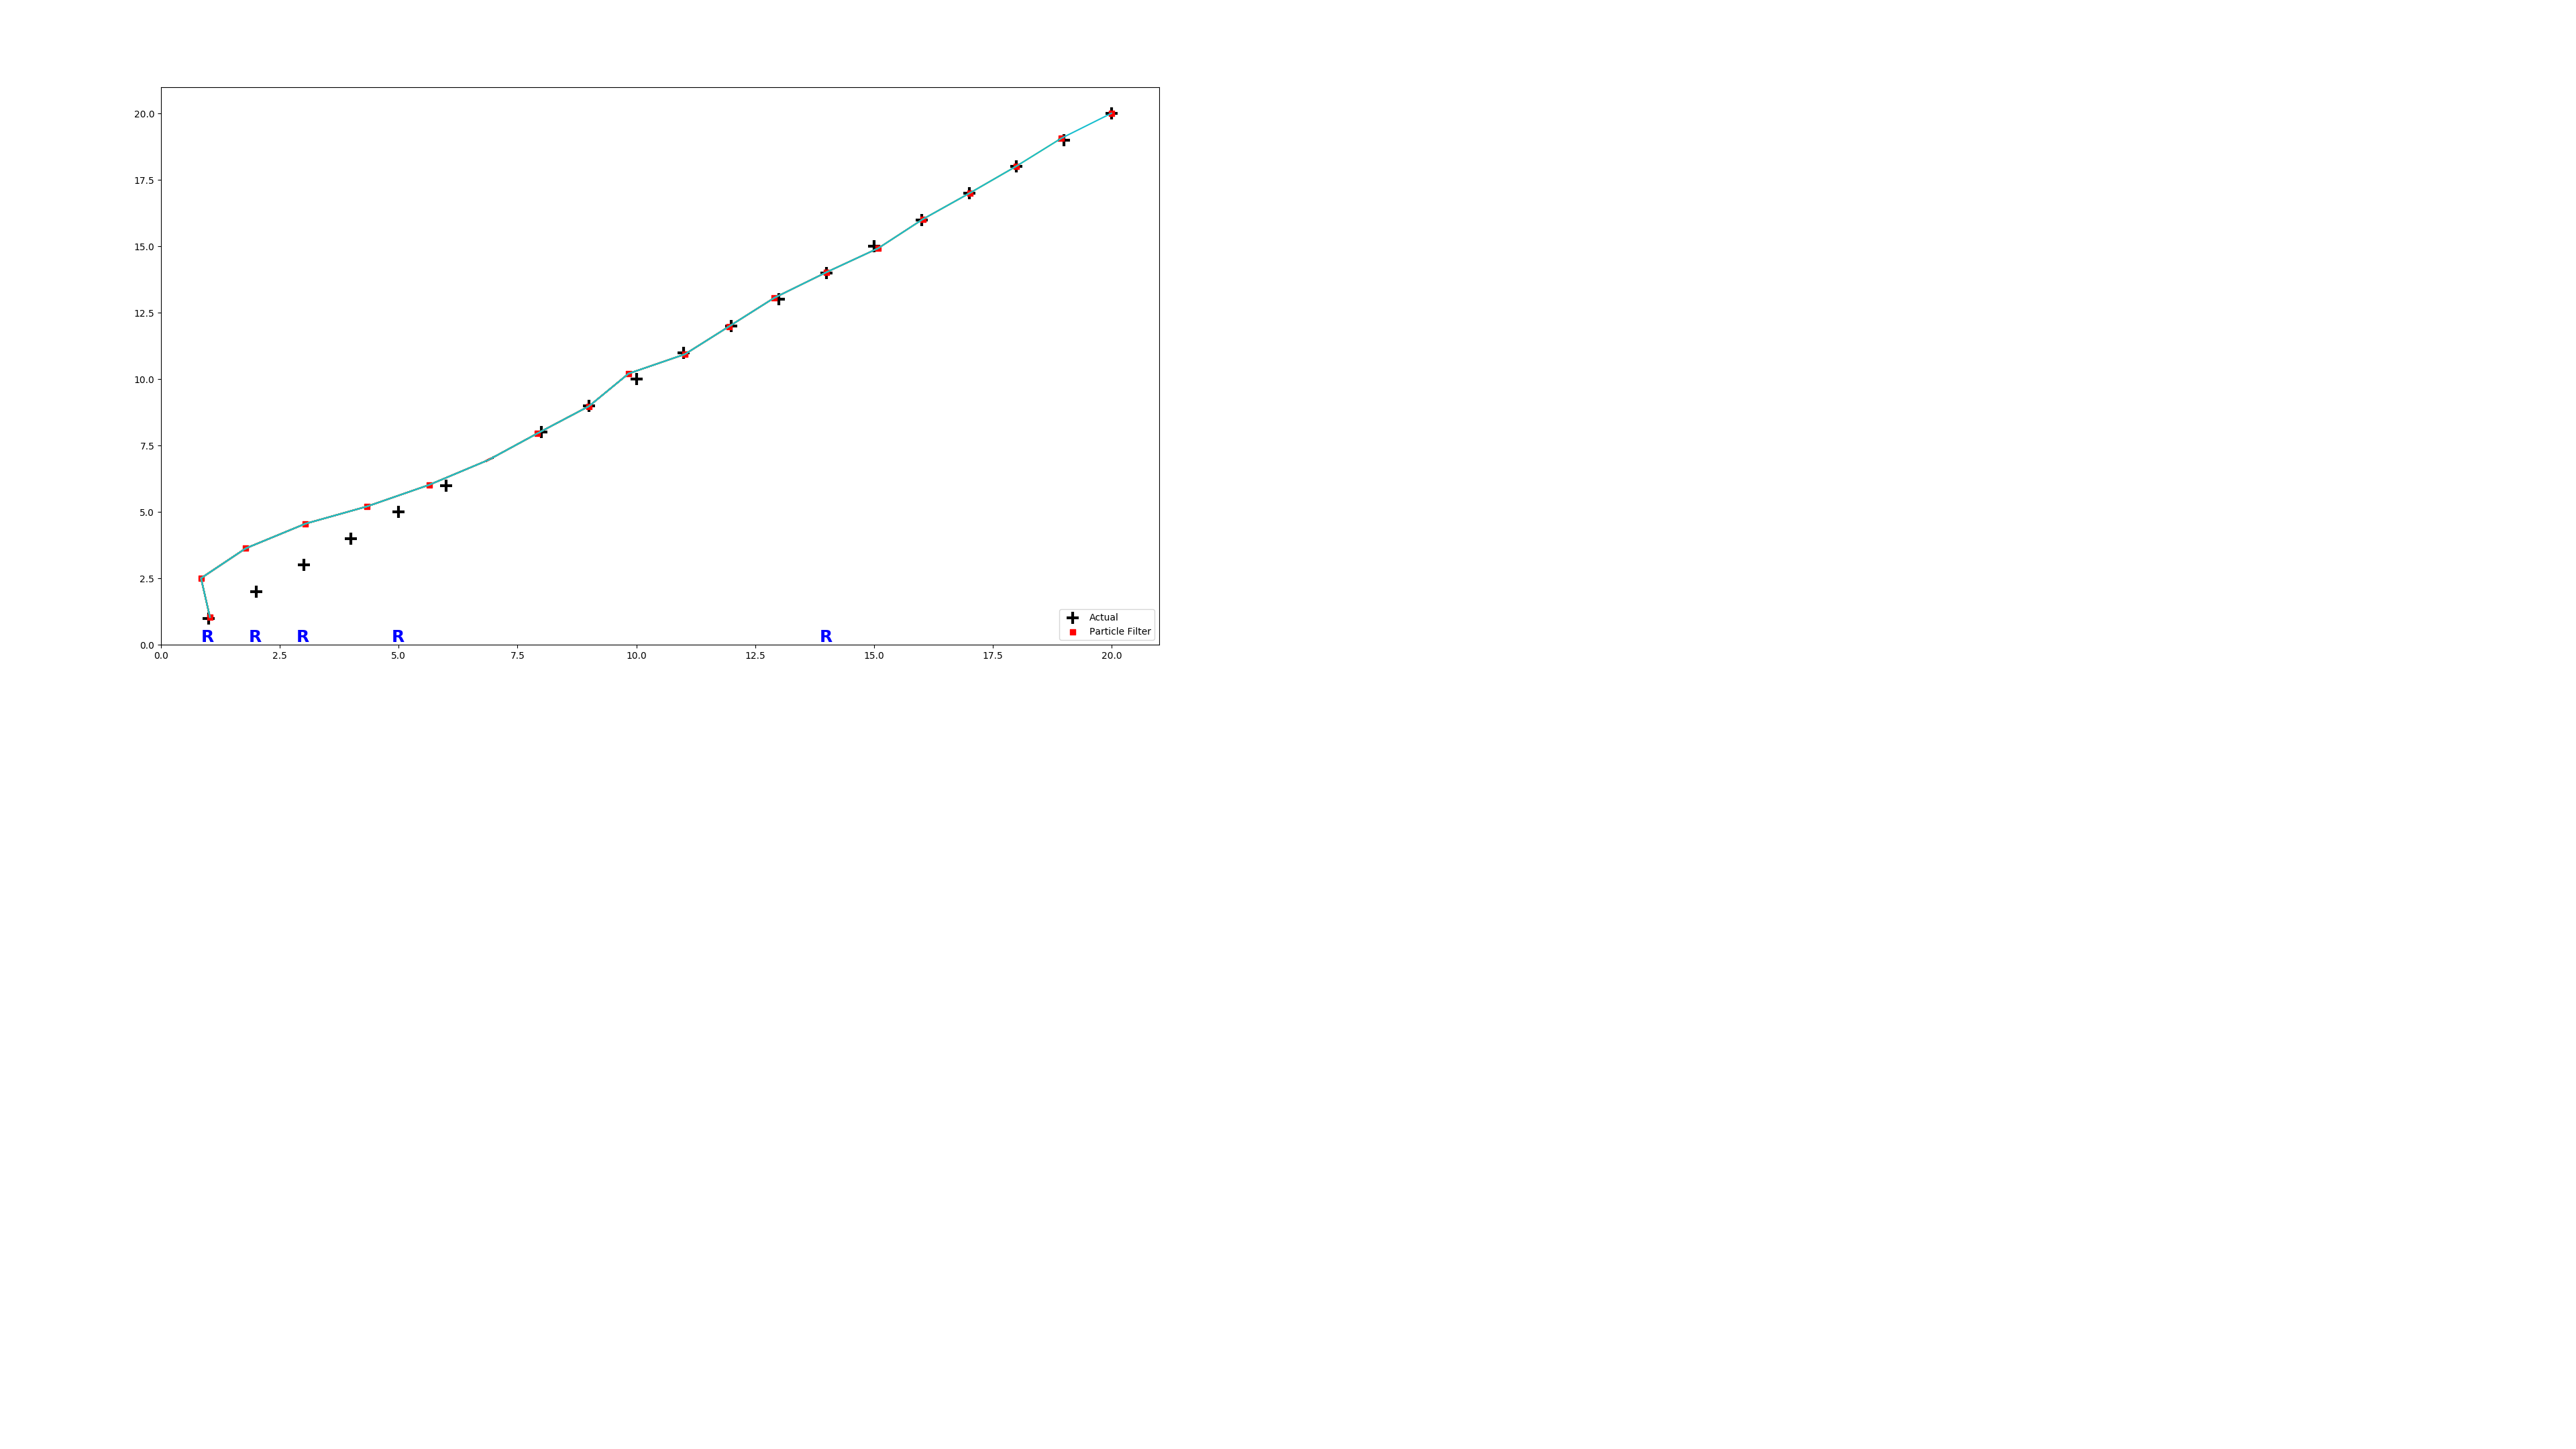

KeyboardInterrupt: 

In [204]:
%matplotlib notebook

N_particles, num_iterations, num_seeds = 30000, 20, 10

the_fig, ax = plt.subplots(1,1, figsize=(16 * 1.2, 9 * 1.2))
ax.set_xlabel('X')
ax.set_ylabel('Y')

for one_seed in range(num_seeds):
    plt.clf()
    fig = run_particle_filter(N_particles=N_particles,
                    plot_trace=True,
                    plot_particles=False,
                    plot_trace_line=True,
                    num_iterations=num_iterations,
                    does_resampling=True,
                    does_slow_down=False,
                    x_lim=(0, num_iterations+1), y_lim=(0, num_iterations+1),
                             fig_=the_fig)
    
    sleep(1.5)

# keep last iteration in the plot window
the_fig.set_figheight(9*0.5)
the_fig.set_figwidth(16*0.5)
the_fig.canvas.draw()

<IPython.core.display.Javascript object>


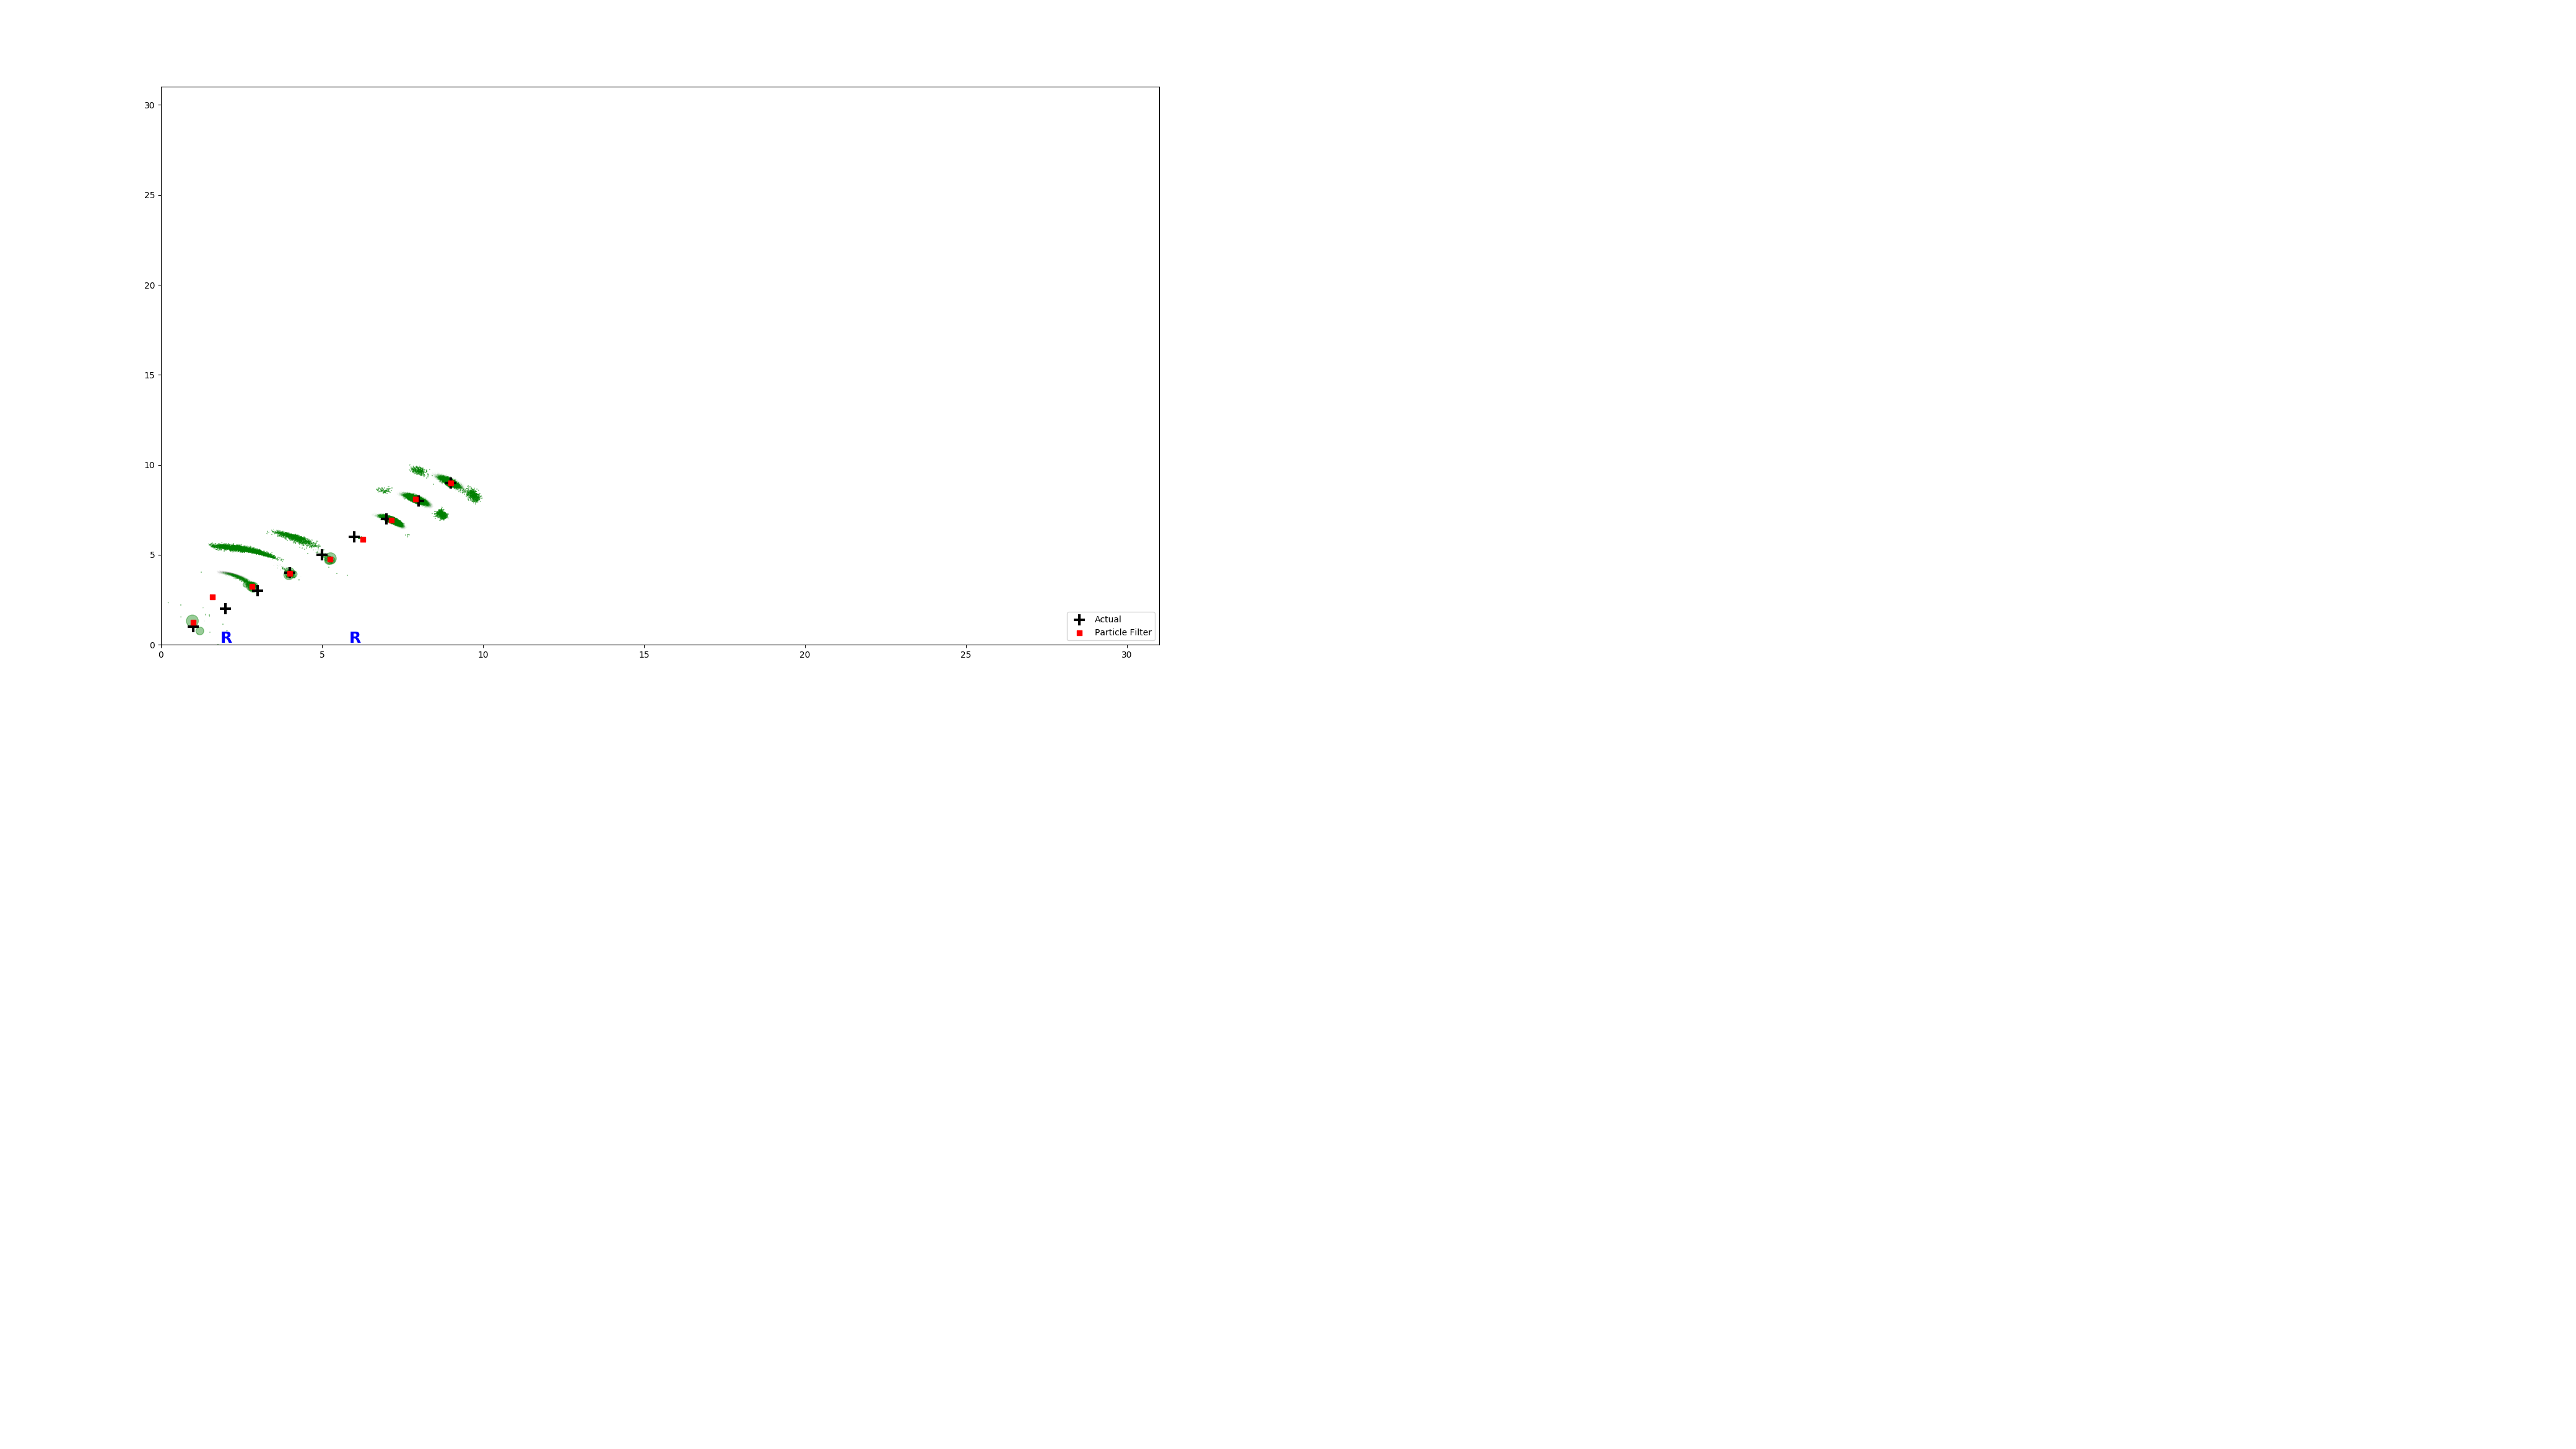

In [ ]:
%matplotlib notebook
seed(2)

N_particles, num_iterations, num_seeds, fig_scale = 5000, 30, 1, 1.3

the_fig, ax = plt.subplots(1,1, figsize=(16 * fig_scale, 9 * fig_scale))
ax.set_xlabel('X')
ax.set_ylabel('Y')

for one_seed in range(num_seeds):

    plt.clf()
    fig = run_particle_filter(N_particles=N_particles,
                    plot_trace=True,
                    plot_particles=True,
                    num_iterations=num_iterations,
                    does_resampling=True,
                    x_lim=(0, num_iterations+1), y_lim=(0, num_iterations+1),
                             fig_=the_fig)


# keep last iteration in the plot window
the_fig.set_figheight(9*0.6)
the_fig.set_figwidth(16*0.6)
the_fig.canvas.draw()

----------------
# END

<img src="img/resampling_examples.png"  alt="Drawing" style="width: 600px;"/>
